[I 2024-08-04 13:05:47,866] A new study created in memory with name: no-name-c1806459-b586-4a6c-a087-fd1196987789
[I 2024-08-04 13:05:47,984] Trial 0 finished with value: 3.5224233045481155 and parameters: {'n_estimators': 344, 'learning_rate': 0.06420598545337827, 'max_depth': 8, 'subsample': 0.6755509913808568, 'min_samples_split': 4, 'min_samples_leaf': 10}. Best is trial 0 with value: 3.5224233045481155.
[I 2024-08-04 13:05:48,077] Trial 1 finished with value: 3.640787142178305 and parameters: {'n_estimators': 324, 'learning_rate': 0.012364617567390886, 'max_depth': 5, 'subsample': 0.674957124999003, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 0 with value: 3.5224233045481155.
[I 2024-08-04 13:05:48,167] Trial 2 finished with value: 3.6408465027465398 and parameters: {'n_estimators': 362, 'learning_rate': 0.08318967774508829, 'max_depth': 10, 'subsample': 0.6336595264209548, 'min_samples_split': 9, 'min_samples_leaf': 7}. Best is trial 0 with value: 3.522423304548

Best Parameters: {'n_estimators': 89, 'learning_rate': 0.19730570001672687, 'max_depth': 7, 'subsample': 0.8109017926851974, 'min_samples_split': 3, 'min_samples_leaf': 4}
Mean Squared Error with Gradient Boosting: 1.4443472326936706
R^2 Score with Gradient Boosting: 0.7237118128764914
                   Feature  Importance
0    Low_Fruit_Consump_Pct    0.367904
5     Population_1_Percent    0.222502
4  Low_Income_Half_Percent    0.168912
2     Vehicle_Half_Percent    0.098319
3  Population_Half_Percent    0.074657
1   Low_Veggie_Consump_Pct    0.067706


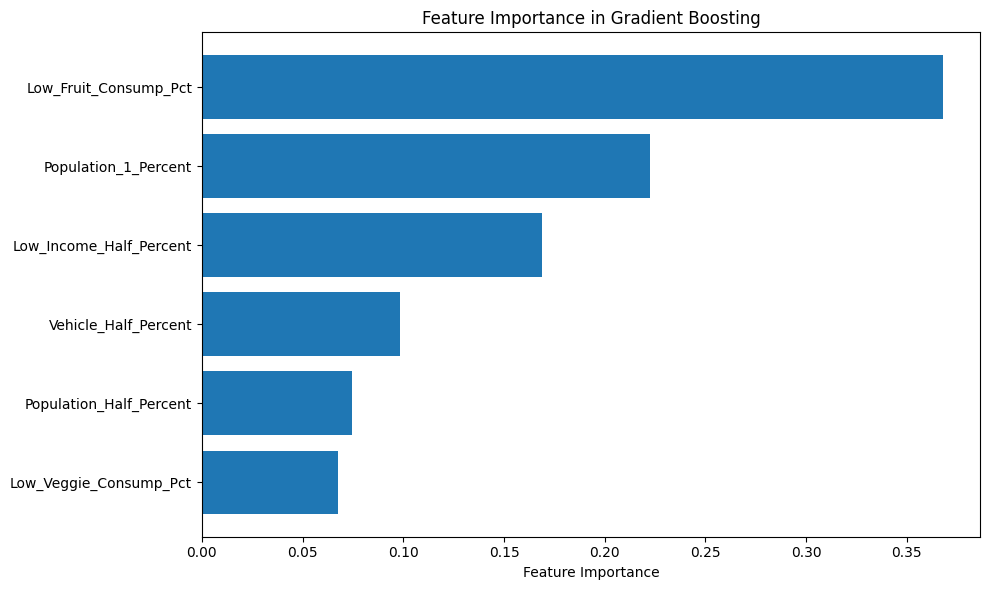

In [13]:
import optuna
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Load and preprocess the data
df = pd.read_csv('../data/data-state-for-processing/merged_dataset.csv')
df = df.drop(columns=['State', 'Unnamed: 0_x', 'Unnamed: 0_y', 'Unnamed: 0']).dropna()
df = df.rename(columns={'Mean_Fruit_Consump_Pct': 'Low_Fruit_Consump_Pct', 'Mean_Veggie_Consump_Pct': 'Low_Veggie_Consump_Pct'})

# Select top features based on previous importance
top_features = ['Low_Fruit_Consump_Pct', 'Low_Veggie_Consump_Pct', 'Vehicle_Half_Percent',
                'Population_Half_Percent', 'Low_Income_Half_Percent', 'Population_1_Percent']
X = df[top_features]
y = df['Mean_Obesity_Pct']

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10)
    }

    model = GradientBoostingRegressor(**params, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse

# Create a study and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Best parameters
print(f"Best Parameters: {study.best_params}")

# Train the best model
best_params = study.best_params
best_gb = GradientBoostingRegressor(**best_params, random_state=42)
best_gb.fit(X_train, y_train)

# Predict and evaluate the best model
y_pred = best_gb.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error with Gradient Boosting: {mse}")
print(f"R^2 Score with Gradient Boosting: {r2}")

# Feature importance
importances = best_gb.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': top_features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

# Plot feature importance
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Gradient Boosting')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.savefig('combined_scatter_plots_county.png', dpi=300, bbox_inches='tight')

plt.show()

In [14]:
import joblib

model_filename = 'gradient-boosting-model.pkl'
joblib.dump(best_gb, model_filename)
print(f"Model saved as {model_filename}")

Model saved as gradient-boosting-model.pkl
